# Peter a vlk: Realistické prostredie

V našej situácii sa Peter mohol pohybovať takmer bez toho, aby sa unavil alebo vyhladol. V realistickejšom svete si však musí občas sadnúť a oddýchnuť si, a tiež sa najesť. Urobme náš svet realistickejším zavedením nasledujúcich pravidiel:

1. Pri presune z jedného miesta na druhé Peter stráca **energiu** a získava **únavu**.
2. Peter môže získať viac energie jedením jabĺk.
3. Peter sa môže zbaviť únavy odpočinkom pod stromom alebo na tráve (t.j. vstúpením na políčko s stromom alebo trávou - zelené pole).
4. Peter musí nájsť a zabiť vlka.
5. Aby Peter dokázal zabiť vlka, musí mať určité úrovne energie a únavy, inak prehrá súboj.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

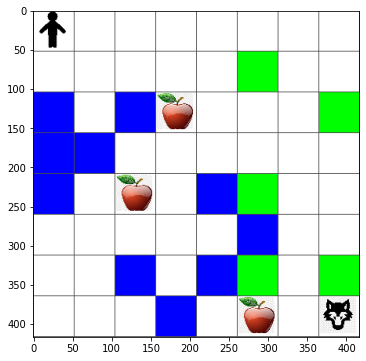

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definovanie stavu

V našich nových pravidlách hry musíme sledovať energiu a únavu v každom stave hracej plochy. Preto vytvoríme objekt `state`, ktorý bude obsahovať všetky potrebné informácie o aktuálnom stave problému, vrátane stavu hracej plochy, aktuálnych úrovní energie a únavy, a či môžeme poraziť vlka v terminálnom stave:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Funkcia odmeny

### Úvod
Funkcia odmeny je kľúčovým prvkom pri navrhovaní systémov posilňovacieho učenia. Definuje cieľ, ktorý sa agent snaží dosiahnuť, a poskytuje spätnú väzbu na základe jeho akcií.

### Základné princípy
- **Jasnosť**: Funkcia odmeny by mala byť jednoduchá a ľahko pochopiteľná.
- **Konzistentnosť**: Mala by byť konzistentná s cieľmi systému.
- **Vyváženosť**: Treba zabezpečiť, aby odmeny neboli príliš vysoké alebo nízke, čo by mohlo ovplyvniť správanie agenta.

### Príklad
Nasledujúci príklad ukazuje, ako môže byť funkcia odmeny implementovaná:

```python
def reward_function(state, action):
    if state == "goal_state":
        return 100
    elif action == "invalid_action":
        return -10
    else:
        return 0
```

### Bežné chyby
- **Príliš zložité funkcie odmeny**: Môžu zmiasť agenta a spomaliť proces učenia.
- **Nedostatočné odmeny**: Ak agent nedostáva dostatočnú spätnú väzbu, môže mať problém naučiť sa správne správanie.
- **Neúmyselné odmeny**: Nesprávne navrhnutá funkcia môže odmeňovať neželané správanie.

### Tipy na optimalizáciu
- Testujte funkciu odmeny v rôznych scenároch.
- Sledujte správanie agenta a upravujte odmeny podľa potreby.
- Zvážte použitie kombinácie pozitívnych a negatívnych odmien na dosiahnutie rovnováhy.

### Záver
Funkcia odmeny je základným stavebným prvkom úspešného systému posilňovacieho učenia. Dôkladné plánovanie a testovanie sú nevyhnutné na zabezpečenie jej efektívnosti.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritmus Q-Learning

Samotný algoritmus učenia zostáva takmer nezmenený, len používame `state` namiesto samotnej pozície na hracej ploche.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

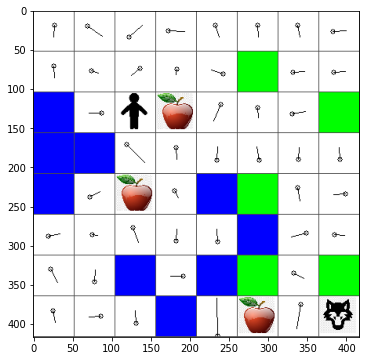

In [11]:
m.plot(Q)

## Výsledky

Pozrime sa, či sme boli úspešní v tréningu Petra, aby bojoval proti vlkovi!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Teraz vidíme oveľa menej prípadov utopenia, ale Peter stále nie je vždy schopný zabiť vlka. Skúste experimentovať a zistiť, či môžete tento výsledok zlepšiť úpravou hyperparametrov.


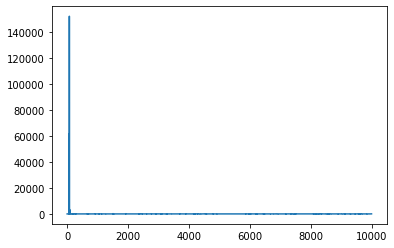

In [13]:
plt.plot(lpath)


---

**Upozornenie**:  
Tento dokument bol preložený pomocou služby AI prekladu [Co-op Translator](https://github.com/Azure/co-op-translator). Hoci sa snažíme o presnosť, prosím, berte na vedomie, že automatizované preklady môžu obsahovať chyby alebo nepresnosti. Pôvodný dokument v jeho rodnom jazyku by mal byť považovaný za autoritatívny zdroj. Pre kritické informácie sa odporúča profesionálny ľudský preklad. Nenesieme zodpovednosť za akékoľvek nedorozumenia alebo nesprávne interpretácie vyplývajúce z použitia tohto prekladu.
